In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import statsmodels.stats.multitest
import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.font_manager
mpl.rcParams['pdf.fonttype'] = 42
font = {'size'   : 12}
plt.rc('font', **font)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
dpi=100

/home/AD/jchien/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
fulldata=pd.read_csv('/cndd2/junhao/ALS_FTD_singleCell/snRNA_postCellBender/DE_MAST/second_round_level_2/MAST_res_level2_summary.txt',sep='\t')
fulldata=fulldata[(fulldata['cond_1']=='ALS')& (fulldata['cond_2']=='Control')]
fulldata['types']=fulldata['region']+'_'+fulldata['cell_type']
fulldata['logFDR']=-np.log10(fulldata['FDR'])
data=fulldata[(fulldata['conv_C']==True) & (fulldata['conv_D']==True) & 
             (fulldata['model_log2FC_ci_hi']*fulldata['model_log2FC_ci_low'] >0) & 
             (np.abs(fulldata['model_log2FC'] - fulldata['avg_logFC'])<2) &
             (np.abs(fulldata['model_log2FC']) > np.log2(1.2))& (fulldata['FDR']<0.05) 
             ]

In [3]:
GOsummary=pd.read_csv('/cndd2/jchien/project/ALS/GO/GO_postCellBender/GO_summary_full_AP_ALS.csv').append(pd.read_csv('/cndd2/jchien/project/ALS/GO/GO_postCellBender/GO_summary_full_AP_FTD.csv'))
GOgene=pd.read_csv('/cndd2/jchien/project/ALS/GO/GO_postCellBender/hsapiens_geneontology_final.csv')
GO_idtoname=dict(zip(GOsummary['geneSet'], GOsummary['description']))
GO_nametoid=dict(zip(GOsummary['description'], GOsummary['geneSet']))

# GO: Astro

In [4]:
def GO_scatter_region_astro(GO):
    from scipy.stats import pearsonr
    GOOI=GO_nametoid[GO]
    GOIs=set(GOgene[GOgene['ont']==GOOI]['gene_name'])

    for i,types in enumerate(['Astro']):
        comp1=fulldata[(fulldata['types']==f'MCX_{types}')&(fulldata['gene'].isin(GOIs))][['gene','model_log2FC','FDR']].set_index('gene')
        comp2=fulldata[(fulldata['types']==f'mFCX_{types}')&(fulldata['gene'].isin(GOIs))][['gene','model_log2FC','FDR']].set_index('gene')
        df=comp1.join(comp2,how='outer', lsuffix='_MCX',rsuffix='_mFCX')
        df['max']=df[['model_log2FC_MCX', 'model_log2FC_mFCX']].max(axis=1)
        df['Sigificant DE in']='None'
        df.loc[(df['FDR_MCX']<0.05),'Sigificant DE in']='MCX'
        df.loc[(df['FDR_mFCX']<0.05),'Sigificant DE in']='mFCX'
        df.loc[(df['FDR_MCX']<0.05)&(df['FDR_mFCX']<0.05),'Sigificant DE in']='Both'
        n_none=(df['Sigificant DE in']=='None').sum()
        n_MCX=(df['Sigificant DE in']=='MCX').sum()
        n_FCX=(df['Sigificant DE in']=='mFCX').sum()
        n_both=(df['Sigificant DE in']=='Both').sum()
        df.loc[df['Sigificant DE in']=='None','Sigificant DE in']=f'None ({n_none})'
        df.loc[df['Sigificant DE in']=='MCX','Sigificant DE in']=f'MCX ({n_MCX})'
        df.loc[df['Sigificant DE in']=='mFCX','Sigificant DE in']=f'mFCX ({n_FCX})'
        df.loc[df['Sigificant DE in']=='Both','Sigificant DE in']=f'Both ({n_both})'
        
        plt.figure(figsize=(5,5),dpi=dpi)
        plt.axvline(x=0,c='grey',linestyle='--',linewidth=0.5)
        plt.axhline(y=0,c='grey',linestyle='--',linewidth=0.5)
        plt.plot([-2.5,4.5],[-2.5,4.5],c='grey',linestyle='--',linewidth=0.5)
        ax=sns.scatterplot(x='model_log2FC_MCX',y='model_log2FC_mFCX',data=df,hue='Sigificant DE in',
                    hue_order=[f'MCX ({n_MCX})',f'mFCX ({n_FCX})',f'Both ({n_both})',f'None ({n_none})'],
                    palette=['#442667','#faa61c','r','lightgrey'],
                   linewidth=0,s=10)
        ax.set_xlim([-2.5,4.5])
        ax.set_ylim([-2.5,4.5])
        
        r,p=pearsonr(df.dropna()['model_log2FC_MCX'],df.dropna()['model_log2FC_mFCX'])
        print(f'r={r},p={p}')
        ax.set_title(GO)
        ax.set_ylabel('$log_{2}$FC (ALS/Control)\nFrontal')
        ax.set_xlabel('$log_{2}$FC (ALS/Control)\nMotor')
        

        texts=[]
        df_sub=df[df['Sigificant DE in']!='None'].sort_values(['max']).tail(5)
        for i, txt in enumerate(df_sub.index.values):
            texts.append(plt.text(df_sub['model_log2FC_MCX'].iloc[i], df_sub['model_log2FC_mFCX'].iloc[i],txt,fontsize=8))

r=0.6975423408800141,p=1.2130134556533063e-24


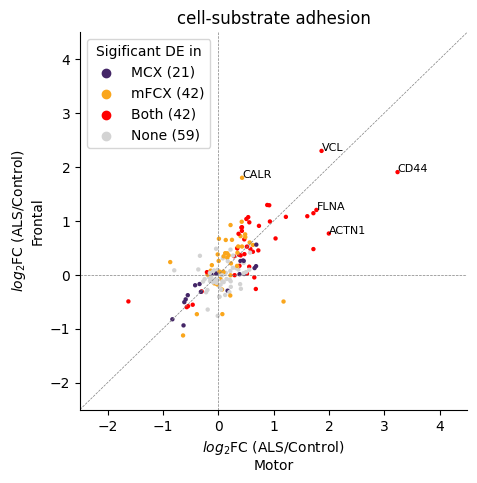

In [5]:
GO_scatter_region_astro('cell-substrate adhesion')

r=0.7438562825055322,p=1.0106767821748775e-40


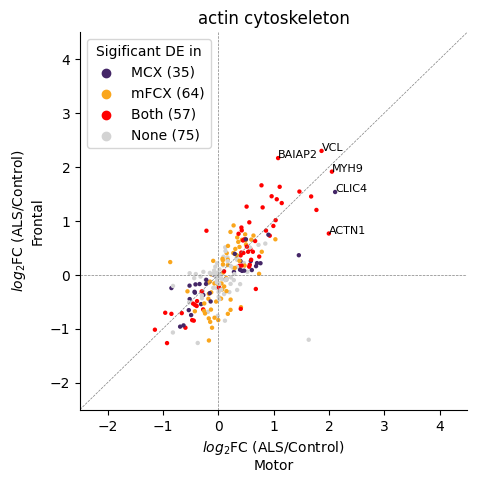

In [6]:
GO_scatter_region_astro('actin cytoskeleton')

r=0.7557682841789068,p=1.3595860264658907e-26


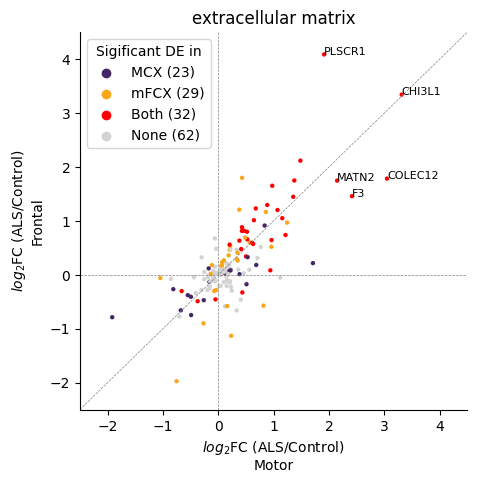

In [7]:
GO_scatter_region_astro('extracellular matrix')

r=0.7339453757986629,p=1.0115041764482217e-31


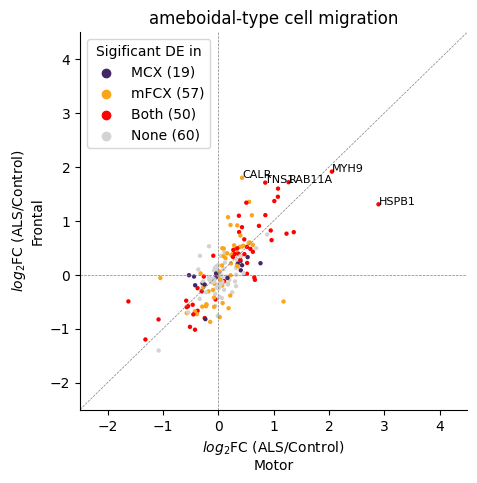

In [8]:
GO_scatter_region_astro('ameboidal-type cell migration')

# GO: Exc

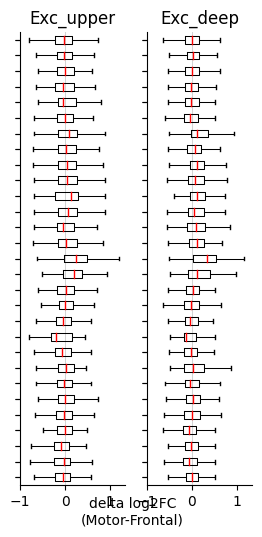

,p_upper,p_deep,fdr_upper,fdr_deep
DE genes,0.159376,0.144557,0.34327,0.252975
protein folding,0.220824,0.768297,0.397844,0.871657
heat shock protein binding,0.843098,0.39839,0.874323,0.619717
unfolded protein binding,0.231204,0.539248,0.397844,0.686316
Golgi-associated vesicle,0.626622,0.242905,0.731059,0.400079
respiratory chain,0.108217,0.00014,0.27546,0.000783
mitochondrial inner membrane,0.000137,0.000002,0.001282,0.00002
mitochondrial protein complex,0.001061,0.0,0.00594,0.0
nucleoside triphosphate metabolic process,0.001875,0.000024,0.008749,0.00017
NADH dehydrogenase complex,0.33088,0.010156,0.463232,0.025852


In [9]:

GOs=['protein folding',
  'heat shock protein binding',
  'unfolded protein binding',
  'Golgi-associated vesicle',
  
  'respiratory chain',
  'mitochondrial inner membrane',
  'mitochondrial protein complex',
  'nucleoside triphosphate metabolic process',
  'NADH dehydrogenase complex',
  'NADH dehydrogenase complex assembly',
  'proton transmembrane transport',
  'mitochondrial membrane organization',
  
  'protein localization to endoplasmic reticulum',
  'polysome',
  'translational elongation',
  
  'protein localization to nucleus',
  'RNA localization',
  'DNA damage response, detection of DNA damage',
  'nucleotide-excision repair',
  
  'antibiotic metabolic process',
  'nucleobase-containing compound transport',
  'ribonucleoprotein complex biogenesis',
  'process utilizing autophagic mechanism',
  'microtubule cytoskeleton organization involved in mitosis',
  'tRNA metabolic process',
  'organelle fission',
  'DNA biosynthetic process'

]

N=pd.DataFrame(index=['all genes','DE genes']+GOs,columns=['N_upper','N_deep'])
P=pd.DataFrame(index=['DE genes']+GOs,columns=['p_upper','p_deep'])

fig,axs=plt.subplots(1,2,figsize=(3,6),dpi=100,sharex=True,sharey=True)

ax=axs[0]
fulldata_sub=fulldata[fulldata['cell_type']=='Exc_superficial'].pivot(index='gene',columns='region',values='model_log2FC')
fulldata_sub['diff']=fulldata_sub['MCX']-fulldata_sub['mFCX']
fulldata_sub=fulldata_sub.dropna()

data_sub=data[data['cell_type']=='Exc_superficial'].pivot(index='gene',columns='region',values='model_log2FC')
data_sub['diff']=data_sub['MCX']-data_sub['mFCX']
data_sub=data_sub.dropna()

# bg comparison
df=[fulldata_sub['diff'].values,data_sub['diff'].values]
s,p=scipy.stats.ttest_ind(df[0],df[1], equal_var=False)
N.loc['all genes','N_upper']=len(df[0])
N.loc['DE genes','N_upper']=len(df[1])
P.loc['DE genes','p_upper']=p

# GO comparison
for GO in GOs:
    GOIs=set(GOgene[GOgene['ont']==GO_nametoid[GO]]['gene_name'])
    GOIs_overlap=GOIs.intersection(set(fulldata_sub.index))
    GO_genes=fulldata_sub.loc[GOIs_overlap]
    df.append(GO_genes['diff'].values)
    s,p=scipy.stats.ttest_ind(df[0],GO_genes['diff'].values, equal_var=False)
    N.loc[GO,'N_upper']=len(GO_genes['diff'].values)
    P.loc[GO,'p_upper']=p
ax.axvline(x=0,linewidth=0.75,c='lightgrey')
ax.boxplot(df,showfliers=False,boxprops=dict(linewidth=0.75),whiskerprops=dict(linewidth=0.75), medianprops = dict(color = "red"),vert=False) 
ax.set_yticklabels(['all genes','DE genes']+GOs)
ax.set_title('Exc_upper')

ax=axs[1]
tmp=fulldata[fulldata['cell_type']=='Exc_deep'].pivot(index='gene',columns='region',values='model_log2FC')
tmp['diff']=tmp['MCX']-tmp['mFCX']
tmp=tmp.dropna()
tmp2=data[data['cell_type']=='Exc_deep'].pivot(index='gene',columns='region',values='model_log2FC')
tmp2['diff']=tmp2['MCX']-tmp2['mFCX']
tmp2=tmp2.dropna()

df=[tmp['diff'].values,tmp2['diff'].values]
s,p=scipy.stats.ttest_ind(df[0],df[1], equal_var=False)
N.loc['all genes','N_deep']=len(df[0])
N.loc['DE genes','N_deep']=len(df[1])
P.loc['DE genes','p_deep']=p

for GO in GOs:
    GOIs=set(GOgene[GOgene['ont']==GO_nametoid[GO]]['gene_name'])
    GOIs_overlap=GOIs.intersection(set(tmp.index))
    GO_genes=tmp.loc[GOIs_overlap]
    df.append(GO_genes['diff'].values)
    s,p=scipy.stats.ttest_ind(df[0],GO_genes['diff'].values, equal_var=False)
    N.loc[GO,'N_deep']=len(GO_genes['diff'].values)
    P.loc[GO,'p_deep']=p
ax.axvline(x=0,linewidth=0.75,c='lightgrey')
ax.boxplot(df,showfliers=False,boxprops=dict(linewidth=0.75),whiskerprops=dict(linewidth=0.75), medianprops = dict(color = "red"),vert=False) 
ax.set_yticklabels('')
ax.invert_yaxis()
ax.set_title('Exc_deep')

ax.set_xlim([-1.01,1.35])
fig.text(0.5, 0.06, "delta log2FC\n(Motor-Frontal)", ha='center')
plt.show()
_,P['fdr_upper']=statsmodels.stats.multitest.fdrcorrection(P['p_upper'])
_,P['fdr_deep']=statsmodels.stats.multitest.fdrcorrection(P['p_deep'])
P

In [10]:
def GO_scatter_region(GO):
    from scipy.stats import pearsonr
    GOOI=GO_nametoid[GO]
    GOIs=set(GOgene[GOgene['ont']==GOOI]['gene_name'])
    fig,axs=plt.subplots(1,2,figsize=(10,4),dpi=dpi,sharex=True,sharey=True)

    for i,types in enumerate(['Exc_superficial','Exc_deep']):
        ax=axs[i]
        comp1=fulldata[(fulldata['types']==f'MCX_{types}')&(fulldata['gene'].isin(GOIs))][['gene','model_log2FC','FDR']].set_index('gene')
        comp2=fulldata[(fulldata['types']==f'mFCX_{types}')&(fulldata['gene'].isin(GOIs))][['gene','model_log2FC','FDR']].set_index('gene')
        df=comp1.join(comp2,how='outer', lsuffix='_MCX',rsuffix='_mFCX')
        df['max']=df[['model_log2FC_MCX', 'model_log2FC_mFCX']].max(axis=1)
        df['Sigificant DE in']='None'
        df.loc[(df['FDR_MCX']<0.05),'Sigificant DE in']='MCX'
        df.loc[(df['FDR_mFCX']<0.05),'Sigificant DE in']='mFCX'
        df.loc[(df['FDR_MCX']<0.05)&(df['FDR_mFCX']<0.05),'Sigificant DE in']='Both'
        n_none=(df['Sigificant DE in']=='None').sum()
        n_MCX=(df['Sigificant DE in']=='MCX').sum()
        n_FCX=(df['Sigificant DE in']=='mFCX').sum()
        n_both=(df['Sigificant DE in']=='Both').sum()
        df.loc[df['Sigificant DE in']=='None','Sigificant DE in']=f'None ({n_none})'
        df.loc[df['Sigificant DE in']=='MCX','Sigificant DE in']=f'MCX ({n_MCX})'
        df.loc[df['Sigificant DE in']=='mFCX','Sigificant DE in']=f'mFCX ({n_FCX})'
        df.loc[df['Sigificant DE in']=='Both','Sigificant DE in']=f'Both ({n_both})'

        
        ax.axvline(x=0,c='grey',linestyle='--',linewidth=0.5)
        ax.axhline(y=0,c='grey',linestyle='--',linewidth=0.5)
        ax.plot([-0.8,2.6],[-0.8,2.6],c='grey',linestyle='--',linewidth=0.5)
        sns.scatterplot(x='model_log2FC_MCX',y='model_log2FC_mFCX',data=df,hue='Sigificant DE in',
                    hue_order=[f'MCX ({n_MCX})',f'mFCX ({n_FCX})',f'Both ({n_both})',f'None ({n_none})'],
                    palette=['#442667','#faa61c','r','lightgrey'],
                   linewidth=0,s=10,ax=ax)
        r,p=pearsonr(df.dropna()['model_log2FC_MCX'],df.dropna()['model_log2FC_mFCX'])
        print(f'r={r},p={p}')
        ax.set_xlim(-0.8,2.6)
        ax.set_ylim(-0.8,2.6)
        
        ax.set_ylabel('$log_{2}$Fold-change (ALS/Control)\nFrontal cortex')
        ax.set_xlabel('$log_{2}$Fold-change (ALS/Control)\nMotor cortex')
        if i==0:
            ax.set_title('Excitatory upper')
        else:
            ax.set_title('Excitatory deep')

        texts=[]
        df_sub=df[df['Sigificant DE in']!='None'].sort_values(['max']).tail(5)
        for i, txt in enumerate(df_sub.index.values):
            texts.append(ax.text(df_sub['model_log2FC_MCX'].iloc[i], df_sub['model_log2FC_mFCX'].iloc[i],txt,fontsize=8))
    plt.suptitle(GO,fontweight='bold')

r=0.6436033018282773,p=1.940276051790687e-20
r=0.6389264101378322,p=2.001776859149697e-20


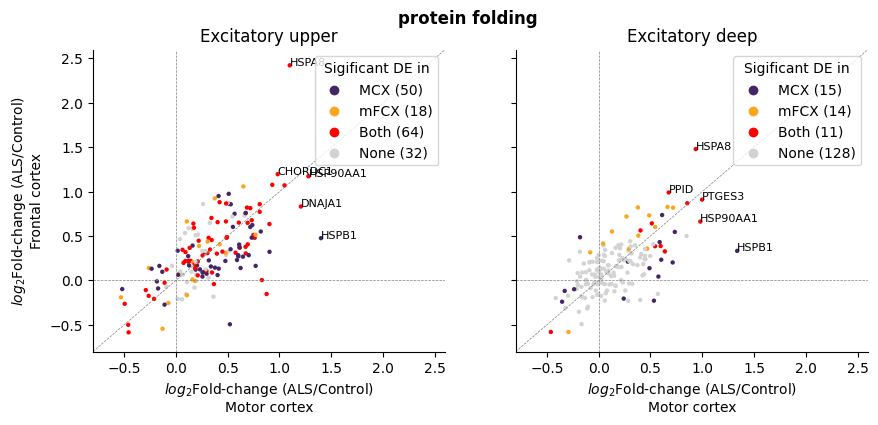

In [11]:
GO_scatter_region('protein folding')

r=0.40475729809010147,p=0.0005099659909513077
r=0.5618623534691058,p=2.817355946083408e-07


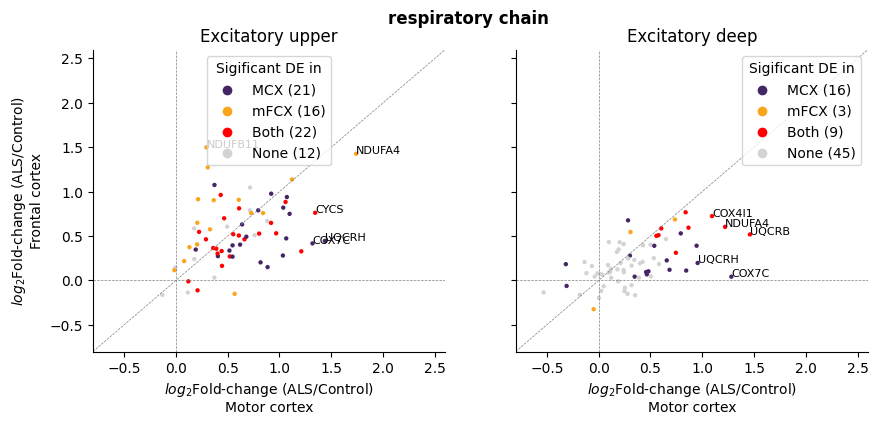

In [12]:
GO_scatter_region('respiratory chain')

r=0.11921524152214565,p=0.1854352092993081
r=0.34122120924539356,p=9.853015302808465e-05


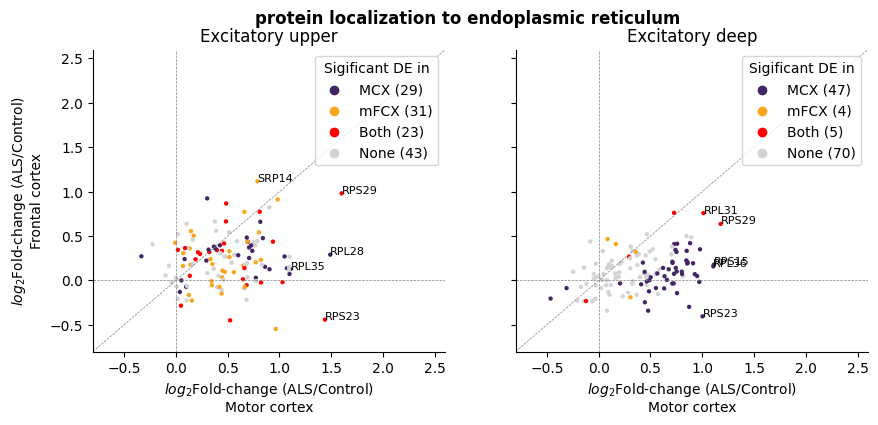

In [13]:
GO_scatter_region('protein localization to endoplasmic reticulum')

# ribosomal genes

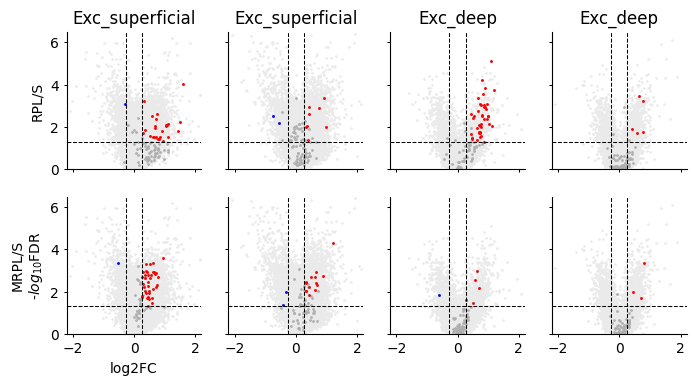

In [14]:
fig,axs=plt.subplots(2,4,figsize=(8,4),sharex=True,sharey=True,dpi=dpi)
ctypes= [ 'Exc_superficial','Exc_deep' ]
n=-1
for i, typp in enumerate(ctypes):
    for j,r in enumerate(['MCX','mFCX']):
        # ax=axs[i,j]
        
        n+=1
        ax=axs[0,n]
        DEs_up=data[(data['cell_type']==typp)&(data['region']==r)&(data['model_log2FC']>0)]
        DEs_dn=data[(data['cell_type']==typp)&(data['region']==r)&(data['model_log2FC']<0)]
        BGs=fulldata[(fulldata['cell_type']==typp)&(fulldata['region']==r)]

        ax.scatter(data=BGs,
                   x='model_log2FC',y='logFDR',
                   s=0.8,c='#EAEAEA',rasterized=True)

        ax.axhline(y=-np.log10(0.05),linestyle='--',linewidth=0.75,c='k')
        ax.axvline(x=np.log2(1.2),linestyle='--',linewidth=0.75,c='k')
        ax.axvline(x=-np.log2(1.2),linestyle='--',linewidth=0.75,c='k')
        
        tmp2=BGs[(BGs['gene'].str.startswith('RPL'))|(BGs['gene'].str.startswith('RPS'))]
        # print(f'BG:{tmp2.shape}')
        ax.scatter(data=tmp2,
                   x='model_log2FC',y='logFDR',
                   s=1,c='#AFAFAF',linewidths=None)
        
        tmp2=DEs_up[(DEs_up['gene'].str.startswith('RPL'))|(DEs_up['gene'].str.startswith('RPS'))]
        # print(f'UP:{tmp2.shape}')
        ax.scatter(data=tmp2,
                   x='model_log2FC',y='logFDR',
                   s=1,c='red',linewidths=None)
        tmp2=DEs_dn[(DEs_dn['gene'].str.startswith('RPL'))|(DEs_dn['gene'].str.startswith('RPS'))]
        # print(f'DN:{tmp2.shape}')
        ax.scatter(data=tmp2,
                   x='model_log2FC',y='logFDR',
                   s=1,c='blue',linewidths=None)
        
        ax.set_title(typp)
        ax.set_ylim([0,6.5])
        ax.set_xlim([-2.2,2.2])
        if (i==0) & (j ==0):
            # ax.set_xlabel('log2FC')
            ax.set_ylabel('RPL/S')
        ax.tick_params('both', length=2, width=0.75, which='major')
# plt.suptitle('Cytoplasmic ribosomal subunit-encoding genes (RPL/S, blue) \n are upregulated in ALS in neurons, especially in deep excitatory neurons')    

n=-1
ctypes= [ 'Exc_superficial','Exc_deep' ]
for i,typp in enumerate(ctypes):
    for j, r in enumerate(['MCX','mFCX']):
        n+=1
        ax=axs[1,n]
        DEs_up=data[(data['cell_type']==typp)&(data['region']==r)&(data['model_log2FC']>0)]
        DEs_dn=data[(data['cell_type']==typp)&(data['region']==r)&(data['model_log2FC']<0)]
        BGs=fulldata[(fulldata['cell_type']==typp)&(fulldata['region']==r)]

        ax.scatter(data=BGs,
                   x='model_log2FC',y='logFDR',
                   s=0.8,c='#EAEAEA',rasterized=True)
        
        ax.axhline(y=-np.log10(0.05),linestyle='--',linewidth=0.75,c='k')
        ax.axvline(x=np.log2(1.2),linestyle='--',linewidth=0.75,c='k')
        ax.axvline(x=-np.log2(1.2),linestyle='--',linewidth=0.75,c='k')
        
        tmp2=BGs[(BGs['gene'].str.startswith('MRPL'))|(BGs['gene'].str.startswith('MRPS'))]
        ax.scatter(data=tmp2,
                   x='model_log2FC',y='logFDR',
                   s=1,c='#AFAFAF')
        
        tmp2=DEs_up[(DEs_up['gene'].str.startswith('MRPL'))|(DEs_up['gene'].str.startswith('MRPS'))]
        ax.scatter(data=tmp2,
                   x='model_log2FC',y='logFDR',
                   s=1,c='red')
        
        tmp2=DEs_dn[(DEs_dn['gene'].str.startswith('MRPL'))|(DEs_dn['gene'].str.startswith('MRPS'))]
        ax.scatter(data=tmp2,
                   x='model_log2FC',y='logFDR',
                   s=1,c='blue')
        ax.set_ylim([0,6.5])
        ax.set_xlim([-2.2,2.2])
        if (i==0) & (j ==0):
            ax.set_xlabel('log2FC')
            ax.set_ylabel('MRPL/S\n-$log_{10}$FDR')
        ax.tick_params('both', length=2, width=0.75, which='major')

Ttest_indResult(statistic=8.726828040104236, pvalue=2.205313603850847e-15) 87 87
Ttest_indResult(statistic=8.041103228742033, pvalue=1.37942273799488e-13) 87 87
Ttest_indResult(statistic=0.6278774809248592, pvalue=0.5310926564800358) 72 72
Ttest_indResult(statistic=1.0018965698295677, pvalue=0.3180977843770469) 72 72


[Text(1, 0, 'Upper Motro'),
 Text(2, 0, 'Upper Frontal'),
 Text(3, 0, 'Deep Motro'),
 Text(4, 0, 'Deep Frontal'),
 Text(1, 0, 'Upper Motro'),
 Text(2, 0, 'Upper Frontal'),
 Text(3, 0, 'Deep Motro'),
 Text(4, 0, 'Deep Frontal')]

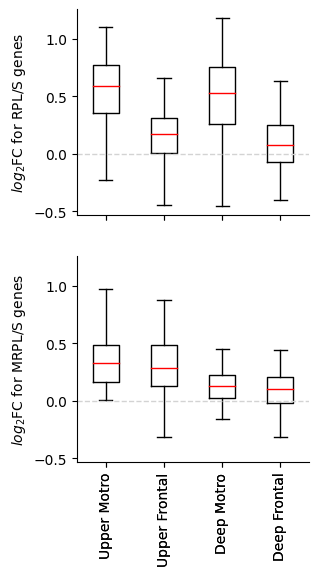

In [15]:
fig,axs=plt.subplots(2,1,figsize=(3,6),sharex=True,sharey=True,dpi=dpi)

ax=axs[0]
ax.set_ylabel('$log_{2}$FC for RPL/S genes')
tmp=fulldata[(fulldata['cell_type'].isin(['Exc_superficial','Exc_deep']))&
             ((fulldata['gene'].str.startswith('RPL'))|(fulldata['gene'].str.startswith('RPS')))].pivot(index='gene',columns='types',values='model_log2FC').dropna()
tmp=tmp[['MCX_Exc_superficial','mFCX_Exc_superficial','MCX_Exc_deep','mFCX_Exc_deep']]
ax.boxplot(tmp,showfliers=False, labels=['MCX_Exc_superficial','mFCX_Exc_superficial','MCX_Exc_deep','mFCX_Exc_deep'], medianprops = dict(color = "red"))
ax.axhline(y=0,linewidth=1,linestyle='--',c='lightgrey')
print(scipy.stats.ttest_ind(tmp['MCX_Exc_deep'], tmp['mFCX_Exc_deep']),len(tmp['MCX_Exc_deep']),len(tmp['mFCX_Exc_deep']))
print(scipy.stats.ttest_ind(tmp['MCX_Exc_superficial'], tmp['mFCX_Exc_superficial']),len(tmp['MCX_Exc_superficial']),len(tmp['mFCX_Exc_superficial']))

ax=axs[1]
ax.set_ylabel('$log_{2}$FC for MRPL/S genes')
tmp=fulldata[(fulldata['cell_type'].isin(['Exc_superficial','Exc_deep']))&
             ((fulldata['gene'].str.startswith('MRPL'))|(fulldata['gene'].str.startswith('MRPS')))].pivot(index='gene',columns='types',values='model_log2FC').dropna()
tmp=tmp[['MCX_Exc_superficial','mFCX_Exc_superficial','MCX_Exc_deep','mFCX_Exc_deep']]
ax.boxplot(tmp,showfliers=False, labels=['MCX_Exc_superficial','mFCX_Exc_superficial','MCX_Exc_deep','mFCX_Exc_deep'], medianprops = dict(color = "red"))
ax.axhline(y=0,linewidth=1,linestyle='--',c='lightgrey')
ax.tick_params(axis='x',labelrotation=90)


print(scipy.stats.ttest_ind(tmp['MCX_Exc_deep'], tmp['mFCX_Exc_deep']),len(tmp['MCX_Exc_deep']),len(tmp['mFCX_Exc_deep']))
print(scipy.stats.ttest_ind(tmp['MCX_Exc_superficial'], tmp['mFCX_Exc_superficial']),len(tmp['MCX_Exc_superficial']),len(tmp['mFCX_Exc_superficial']))
ax.set_xticklabels(['Upper Motro','Upper Frontal','Deep Motro','Deep Frontal','Upper Motro','Upper Frontal','Deep Motro','Deep Frontal'])

# Fig S8

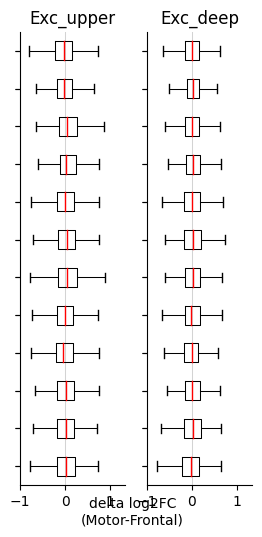

,p_upper,p_deep,fdr_upper,fdr_deep
DE genes,0.159376,0.144557,0.175313,0.386009
synapse organization,0.045891,0.226524,0.078333,0.386009
postsynaptic specialization,0.002708,0.066579,0.029787,0.386009
axon development,0.049848,0.217687,0.078333,0.386009
regulation of neuron projection development,0.027721,0.203077,0.078333,0.386009
negative regulation of nervous system development,0.021198,0.245642,0.078333,0.386009
receptor complex,0.044499,0.360057,0.078333,0.48284
passive transmembrane transporter activity,0.718794,0.423607,0.718794,0.48284
morphogenesis of an epithelium,0.037153,0.438945,0.078333,0.48284
response to alcohol,0.139513,0.944169,0.170515,0.944169


In [16]:
GOs=["synapse organization","postsynaptic specialization" ,
  "axon development",
  "regulation of neuron projection development",
  "negative regulation of nervous system development",
  "receptor complex",
  "passive transmembrane transporter activity",
  "morphogenesis of an epithelium",              
  "response to alcohol",                           
  "regulation of lipid metabolic process"
]

N=pd.DataFrame(index=['all genes','DE genes']+GOs,columns=['N_upper','N_deep'])
P=pd.DataFrame(index=['DE genes']+GOs,columns=['p_upper','p_deep'])

fig,axs=plt.subplots(1,2,figsize=(3,6),dpi=100,sharex=True,sharey=True)

ax=axs[0]
fulldata_sub=fulldata[fulldata['cell_type']=='Exc_superficial'].pivot(index='gene',columns='region',values='model_log2FC')
fulldata_sub['diff']=fulldata_sub['MCX']-fulldata_sub['mFCX']
fulldata_sub=fulldata_sub.dropna()

data_sub=data[data['cell_type']=='Exc_superficial'].pivot(index='gene',columns='region',values='model_log2FC')
data_sub['diff']=data_sub['MCX']-data_sub['mFCX']
data_sub=data_sub.dropna()

# bg comparison
df=[fulldata_sub['diff'].values,data_sub['diff'].values]
s,p=scipy.stats.ttest_ind(df[0],df[1], equal_var=False)
N.loc['all genes','N_upper']=len(df[0])
N.loc['DE genes','N_upper']=len(df[1])
P.loc['DE genes','p_upper']=p

# GO comparison
for GO in GOs:
    GOIs=set(GOgene[GOgene['ont']==GO_nametoid[GO]]['gene_name'])
    GOIs_overlap=GOIs.intersection(set(fulldata_sub.index))
    GO_genes=fulldata_sub.loc[GOIs_overlap]
    df.append(GO_genes['diff'].values)
    s,p=scipy.stats.ttest_ind(df[0],GO_genes['diff'].values, equal_var=False)
    N.loc[GO,'N_upper']=len(GO_genes['diff'].values)
    P.loc[GO,'p_upper']=p
ax.axvline(x=0,linewidth=0.75,c='lightgrey')
ax.boxplot(df,showfliers=False,boxprops=dict(linewidth=0.75),whiskerprops=dict(linewidth=0.75), medianprops = dict(color = "red"),vert=False) 
ax.set_yticklabels(['all genes','DE genes']+GOs)
ax.set_title('Exc_upper')

ax=axs[1]
tmp=fulldata[fulldata['cell_type']=='Exc_deep'].pivot(index='gene',columns='region',values='model_log2FC')
tmp['diff']=tmp['MCX']-tmp['mFCX']
tmp=tmp.dropna()
tmp2=data[data['cell_type']=='Exc_deep'].pivot(index='gene',columns='region',values='model_log2FC')
tmp2['diff']=tmp2['MCX']-tmp2['mFCX']
tmp2=tmp2.dropna()

df=[tmp['diff'].values,tmp2['diff'].values]
s,p=scipy.stats.ttest_ind(df[0],df[1], equal_var=False)
N.loc['all genes','N_deep']=len(df[0])
N.loc['DE genes','N_deep']=len(df[1])
P.loc['DE genes','p_deep']=p

for GO in GOs:
    GOIs=set(GOgene[GOgene['ont']==GO_nametoid[GO]]['gene_name'])
    GOIs_overlap=GOIs.intersection(set(tmp.index))
    GO_genes=tmp.loc[GOIs_overlap]
    df.append(GO_genes['diff'].values)
    s,p=scipy.stats.ttest_ind(df[0],GO_genes['diff'].values, equal_var=False)
    N.loc[GO,'N_deep']=len(GO_genes['diff'].values)
    P.loc[GO,'p_deep']=p
ax.axvline(x=0,linewidth=0.75,c='lightgrey')
ax.boxplot(df,showfliers=False,boxprops=dict(linewidth=0.75),whiskerprops=dict(linewidth=0.75), medianprops = dict(color = "red"),vert=False) 
ax.set_yticklabels('')
ax.invert_yaxis()
ax.set_title('Exc_deep')

ax.set_xlim([-1.01,1.35])
fig.text(0.5, 0.06, "delta log2FC\n(Motor-Frontal)", ha='center')
plt.show()
_,P['fdr_upper']=statsmodels.stats.multitest.fdrcorrection(P['p_upper'])
_,P['fdr_deep']=statsmodels.stats.multitest.fdrcorrection(P['p_deep'])
P